# Scale Invariant Feature Transform (SIFT) Detection
***

In [9]:
# notebook imports
import cv2
import math
import scipy
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

In [10]:
# loading in images 
flowers = cv2.imread('../Image_Data/flowers.jpg')
flowers = cv2.cvtColor(flowers, cv2.COLOR_BGR2RGB)
gray_flowers = cv2.cvtColor(flowers, cv2.COLOR_RGB2GRAY)
gray_flowers.shape

(427, 640)

***
## Scale Space Extrema Detection

In [2]:
# creating gaussian filter
def gaussian_filter(sigma):
    ksize = 2 * np.ceil(3 * sigma) + 1 
    x, y = np.mgrid[-ksize//2 + 1:ksize//2 + 1, -ksize//2 + 1:ksize//2 + 1] 
    # creates gaussian kernel using the 2D gaussian function
    kernel = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
    # returns normalized version of the kernel
    return kernel/kernel.sum()

In [3]:
# generating a Gaussian octave
# IMPORTANT - IF I NOTICE LOSS IN DATA DURING FEATURE EXTRACTION, CHANGE THE DEPTH OF THE ORIGINAL IMG AND OF FILTER2D
def create_gaussian_octave(img, s, sigma):
    octave = [img]
    k = 2 ** (1/s)
    kernel = gaussian_filter(k * sigma)
    for i in range(s + 2):
        scale_up = cv2.filter2D(octave[-1], -1, kernel=kernel)
        octave.append(scale_up)
    
    return octave

In [4]:
# creating Gaussian pyramid
def create_gaussian_pyramid(img, num_octaves, s, sigma):
    g_pyramid = []
    
    for i in range(num_octaves):
        octave = create_gaussian_octave(img, s, sigma)
        g_pyramid.append(octave)
        # scaling down the image and taking the middle to use as base for next octave
        img = octave[-3][::2, ::2]
    
    return g_pyramid

Might have changed the dimensions here to make writing the feature etrema method easier to implement, not sure yet tho

In [59]:
def create_DoG_octave(gaussian_octave):
    DoG_oct = []
    for i in range(1, len(gaussian_octave)):
        DoG_oct.append(gaussian_octave[i] - gaussian_octave[i - 1])
    
    # IMPORTANT DATA CHANGE HERE TO NP ARR
    return np.array(DoG_oct)
    # changes the shape from 7, 427, 640 to 427, 640, 7
#     return np.concatenate([o[:,:,np.newaxis] for o in DoG_oct], axis=2) 

In [29]:
def create_DoG_pyramid(gaussian_pyramid):
    DoG_pyr = []
    
    for octave in gaussian_pyramid:
        DoG_pyr.append(create_DoG_octave(octave))
    
    return DoG_pyr

In [62]:
# not sure why the axes needed to be flipped - ???????
res = create_gaussian_octave(gray_flowers, 5, 1.6)
res_dog = create_DoG_octave(res)
# plt.imshow(res[4][::2, ::2])
# res_dog = np.array(res_dog)
res_dog.shape

(7, 427, 640)

In [27]:
sample = create_gaussian_pyramid(gray_flowers, 4, 5, 1.6)

In [56]:
sample_dog_pyr = create_DoG_pyramid(sample)
sample_dog_pyr = np.array(sample_dog_pyr)
print(sample_dog_pyr.shape, sample_dog_pyr[0].shape, sample_dog_pyr[0][0].shape)

(4, 7) (7,) (427, 640)


In [46]:
# from the above statement, the data is in the following form:
# 4 octaves, with 7 images per octave
# each of spots in each octave contains a 2D array that is the image
# alright, now let's plot local extrema - or try to :D

In [57]:
# alright so the current issue is np slicing for primitive lists does not exist obviously, but would ne much nicer
# this means that either the input has to be converted to a numpy array, or the data beforehand has to be processed 
# as numpy arrays - gonna try it with python primitives first 

In [61]:
# nsize = neighborhood size: default is 3 to sample 26 points in adjacents octave levels
def get_local_extrema(DoG_octave, nsize=3):
    # we need to take local mins and maxes only in adjacent scales
    # go through octaves
    possible_kpoints = []
    offset = nsize//2
    for i in range(1, len(DoG_octave) - 1):
        # go through images in each octave
        for j in range(offset, len(DoG_octave[0]) - offset):
            for k in range(offset, len(DoG_octave[0, 0]) - offset):
                patch = DoG_octave[i - 1:i + 2, j - offset:j + offset + 1, k - offset:k + offset + 1]
                if np.argmax(patch) == 13 or np.argmin(patch) == 13: 
                    # row, col, lvl
                    possible_kpoints.append([j, k, i]) 
                    
    return possible_kpoints

In [65]:
# Sooo, only getting keypoints on lvl 1, might have something to do with lost data due to uint8 typing?
kpoints = get_local_extrema(res_dog)

In [13]:
sigma = 1.6
size = 2*np.ceil(3*sigma)+1 
x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1] 
y

array([[-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]])

In [62]:
# Messing around with LoG function 
def create_LoG(sigma, k_size):
    kernel = np.zeros((k_size, k_size))
    pos_offset = k_size//2
    neg_offset = -pos_offset
    for x in range(neg_offset, pos_offset + 1):
        for y in range(neg_offset, pos_offset + 1):
            r = math.sqrt(x * x + y * y)
            s = 2 * sigma ** 2
            LoG = ((1 - (r * r)/s) * (np.e ** (-((r * r)/s)))) / (-(math.pi * sigma ** 4))
            kernel[x + pos_offset, y + pos_offset] = LoG
    return kernel

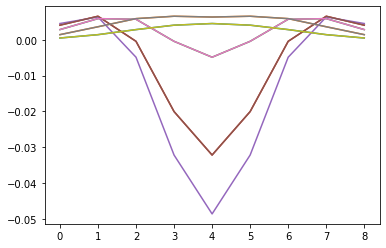

In [78]:
sigma = 1.6
res = create_LoG(sigma, 9)
plt.plot(res)
plt.show()

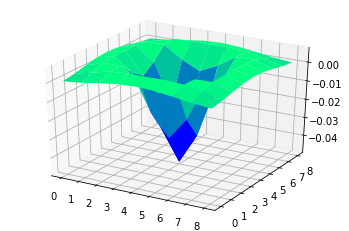

In [79]:
xv, yv = np.mgrid[0:res.shape[0], 0:res.shape[1]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.plot_surface(xv,yv,res, cmap='winter', edgecolor='none')
plt.show()

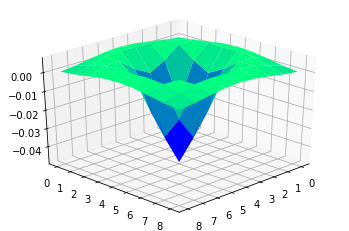

In [84]:
ax.view_init(30, 45)
fig

In [84]:
def DoG_1D(sigma1, sigma2):
    size = (int)(2*np.ceil(3*sigma1)+1)
    pos_offset = size//2
    neg_offset = -pos_offset
    gauss1 = []
    gauss2 = []
    for i in range(neg_offset, pos_offset + 1):
#         g = np.exp(-((i * i)/2 * sigma1 * sigma1)) / (math.sqrt(2 * np.pi) * sigma1)
        g = np.exp(-i * i/2/sigma1/sigma1) / sigma1
        g = g/size
        gauss1.append(g)
    
    i = neg_offset
    while i <= pos_offset:
#         g = np.exp(-((i * i)/(2 * sigma1 * sigma1))) / (math.sqrt(2 * np.pi) * sigma1)
        g = np.exp(-i * i/2/sigma1/sigma1) / sigma1
        gauss2.append(g)
        i += 0.1
    return gauss1, gauss2

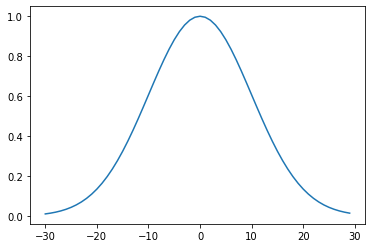

In [64]:
# I think this is fine
sigma1 = 1
size = (int)(2*np.ceil(3*sigma1)+1)
pos_offset = size//2
neg_offset = -pos_offset
res, gauss_res = DoG_1D(sigma1, 0)
x_vals = np.arange(neg_offset * sigma1/0.1, pos_offset * sigma1/0.1, sigma1)
# plt.xticks(np.arange(min(x_vals), max(x_vals)+1, 2.0))
plt.plot(x_vals, gauss_res)

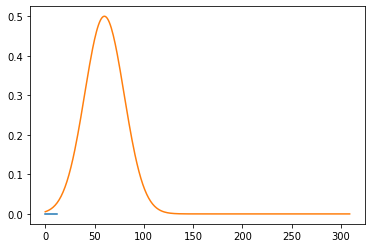

In [81]:
gauss_res1, gauss_res2 = DoG_1D(2, 0)
gauss_res1 = np.array(gauss_res1)
plt.plot(gauss_res1 * len(gauss_res2)//len(gauss_res1))
plt.plot(gauss_res2)
plt.show()

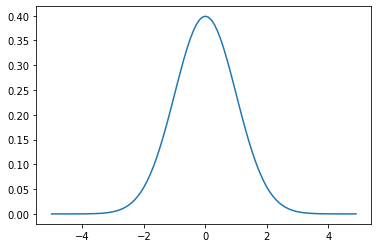

In [72]:
x_values = np.arange(-5, 5, 0.1)
y_values = scipy.stats.norm(0, 1)
plt.plot(x_values, y_values.pdf(x_values))

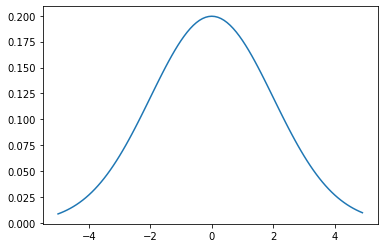

In [73]:
y = scipy.stats.norm(0, 2)
plt.plot(x_values, y.pdf(x_values))

In [75]:
plt.plot(x_values, combined.pdf(x_values))

TypeError: 'rv_frozen' object is not subscriptable

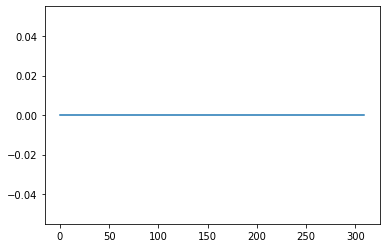

In [83]:
res, gauss_res = DoG_1D(2, 0)
combined = np.array(gauss_res2) - np.array(gauss_res)
plt.plot(combined)

***

## References
* https://medium.com/@lerner98/implementing-sift-in-python-36c619df7945
* https://medium.com/data-breach/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40
* https://en.wikipedia.org/wiki/Scale-invariant_feature_transform
* https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
* https://en.wikipedia.org/wiki/Difference_of_Gaussians